In [ ]:
# HRnet
import os
import cv2
import numpy as np
import tensorflow as tf
import tifffile as tiff
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')



# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'

# Check if the images and masks directories exist
if not os.path.exists(images_path) or not os.path.exists(masks_path):
    raise ValueError("Directory not found.")

# List .tiff images and masks
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])

# Debugging: Print the number of images and masks
print("Number of images:", len(images))
print("Number of masks:", len(masks))

# Ensure they match
if len(images) != len(masks):
    raise ValueError("The number of images and masks do not match.")

# Function to parse cell data from a .txt mask file
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7]),
                    "width": int(parts[6]) - int(parts[4]),
                    "height": int(parts[7]) - int(parts[5])
                }
                cell_data.append(cell)
        return cell_data

# Function to generate a binary mask from cell data
def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)  # Add extra dimension

# Split data into training, validation, and test sets
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Debugging: Print the number of images in each split
print("Training images:", len(train_images))
print("Validation images:", len(val_images))
print("Test images:", len(test_images))

# Function to load .tiff images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Image enhancement and denoising function
def enhance_and_denoise_image(img):
    img = (img * 255).astype(np.uint8)  # Convert to 8-bit for equalization
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if it's RGB
    img = cv2.equalizeHist(img)  # Apply histogram equalization
    img = np.expand_dims(img, axis=-1)  # Add channel dimension if needed
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img
# Function to adjust data values
def adjust_data(img, mask):
    img = enhance_and_denoise_image(img)  # Apply enhancement and denoising
    mask = mask / 255.0  # Normalize mask to 0 and 1
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    return img, mask

# Data Generator Class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=32, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.image_size)
            img = np.expand_dims(img, axis=-1)

            mask = self.load_mask(mask_path)
            mask = cv2.resize(mask, self.image_size)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

    def load_mask(self, mask_path):
        # Read the file and skip rows that contain non-numeric data
        with open(mask_path, 'r') as file:
            mask_data = []
            for line in file:
                # Split each line and filter out lines that don't start with numeric values
                values = line.split()
                if values[0] == 'Cell' and len(values) >= 9:  # Ensure we have enough values
                    # Extract only the relevant numeric coordinates
                    mask_data.append(list(map(int, values[3:9])))

        # Convert the list to a numpy array
        mask_data = np.array(mask_data, dtype=int)

        # Create an empty mask and populate it based on mask_data
        mask = np.zeros((1024, 1024), dtype=np.uint8)  # Assuming the original mask size is 1024x1024
        for cell in mask_data:
            if len(cell) >= 6:  # Check if there are enough values to unpack
                x1, y1, x2, y2 = cell[2:6]  # Unpack only coordinates
                mask[y1:y2, x1:x2] = 1  # Update mask with bounding box

        return mask

# Define the HRNet-like model
def hrnet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, padding='same', activation='relu')(inputs)
    conv2 = Conv2D(64, 3, padding='same', activation='relu')(conv1)
    maxpool1 = MaxPooling2D()(conv2)

    conv3 = Conv2D(128, 3, padding='same', activation='relu')(maxpool1)
    conv4 = Conv2D(128, 3, padding='same', activation='relu')(conv3)
    maxpool2 = MaxPooling2D()(conv4)

    conv5 = Conv2D(256, 3, padding='same', activation='relu')(maxpool2)
    conv6 = Conv2D(256, 3, padding='same', activation='relu')(conv5)
    maxpool3 = MaxPooling2D()(conv6)

    conv7 = Conv2D(512, 3, padding='same', activation='relu')(maxpool3)
    conv8 = Conv2D(512, 3, padding='same', activation='relu')(conv7)

    upsample1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv8)
    concat1 = concatenate([upsample1, conv6], axis=3)
    conv9 = Conv2D(256, 3, padding='same', activation='relu')(concat1)
    conv10 = Conv2D(256, 3, padding='same', activation='relu')(conv9)

    upsample2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv10)
    concat2 = concatenate([upsample2, conv4], axis=3)
    conv11 = Conv2D(128, 3, padding='same', activation='relu')(concat2)
    conv12 = Conv2D(128, 3, padding='same', activation='relu')(conv11)

    upsample3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv12)
    concat3 = concatenate([upsample3, conv2], axis=3)
    conv13 = Conv2D(64, 3, padding='same', activation='relu')(concat3)
    conv14 = Conv2D(64, 3, padding='same', activation='relu')(conv13)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv14)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model and define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model = hrnet_model(input_size=(256, 256, 1))

# Create Data Generators for training and validation
batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

# Train the model
history = model.fit(train_gen,
                    epochs=100,
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Evaluate on the test set
test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
y_pred = model.predict(test_gen)

# Flatten the predictions and true values for ROC analysis
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()

# Compute ROC curve and area
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


Mounted at /content/drive
Number of images: 1117
Number of masks: 1117
Training images: 670
Validation images: 223
Test images: 224
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 560s 6s/step - accuracy: 0.9992 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 446ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 387ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 365ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 387ms/ste

NameError: name 'roc_curve' is not defined

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


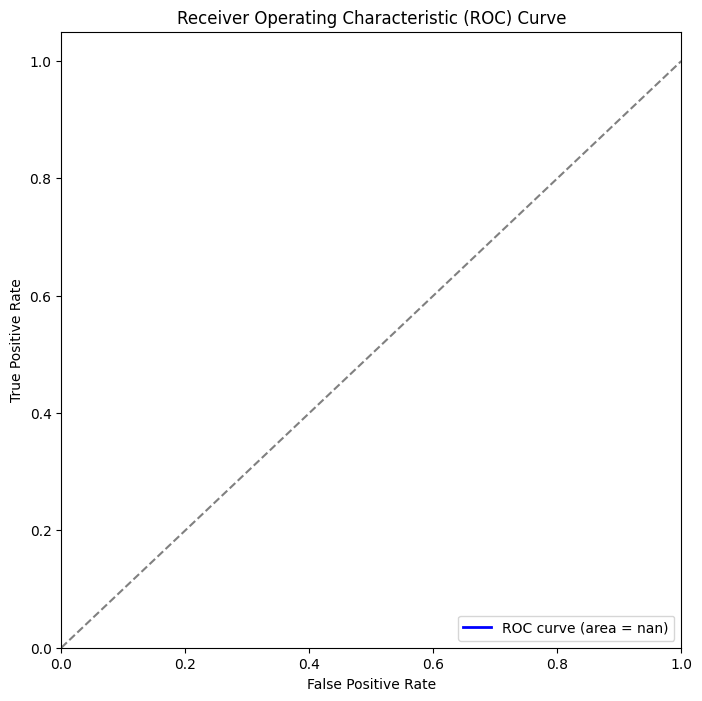

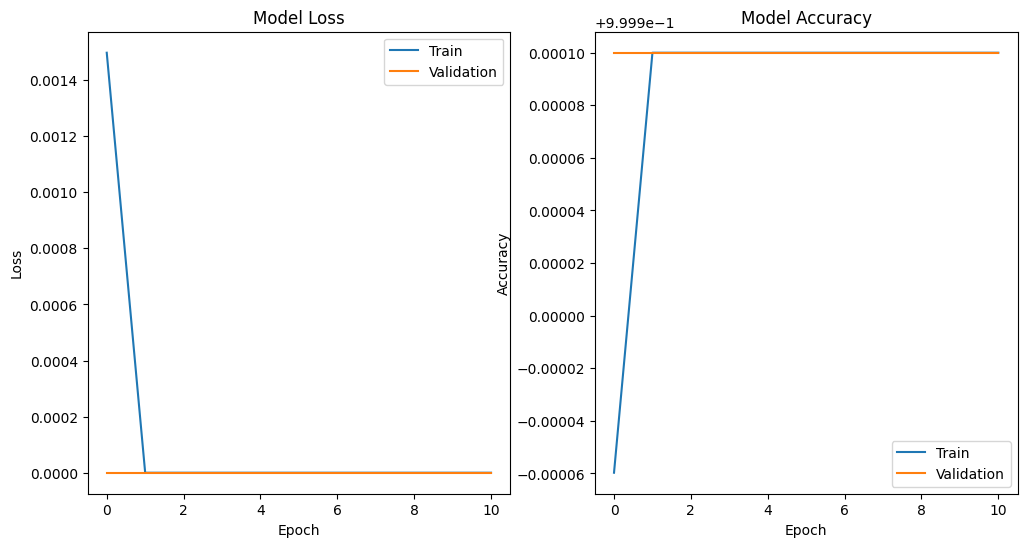

In [ ]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and area
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of images: 1117
Number of masks: 1117
Training images: 670
Validation images: 223
Test images: 224
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9922 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 9.2263e-06
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 1.0000 - loss: 5.7045e-06 - val_accuracy: 1.0000 - val_loss: 4.6881e-06
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 1.0000 - loss: 2.5417e-06 - val_accuracy: 1.0000 - val_loss: 3.0398e-06
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 1.0000 - loss: 2.0306e-06 - val_accuracy: 1.0000 - val_loss: 2.1538e-06
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 1.0000 - loss: 7.1164e-07 - val_accuracy: 1.0000 - val_loss: 4.5881e-07
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 1.0000 - loss: 5.5075e-07 - val_accuracy: 1.0000 - val_loss: 6.0340e-07
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 1.9246e-07 - val_accuracy: 1.0000 - val_loss: 4.3104e-07
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/s

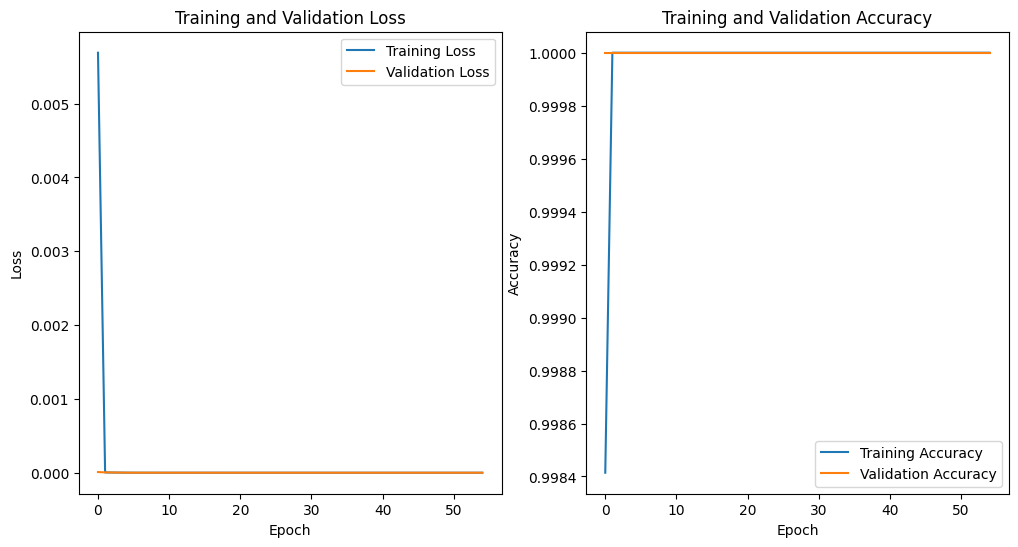

In [ ]:
#Unet Model
import os
import cv2
import numpy as np
import tensorflow as tf
import tifffile as tiff
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')



# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'
# Check if the images and masks directories exist
if not os.path.exists(images_path) or not os.path.exists(masks_path):
    raise ValueError("Directory not found.")

# List .tiff images and masks
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])

# Debugging: Print the number of images and masks
print("Number of images:", len(images))
print("Number of masks:", len(masks))

# Ensure they match
if len(images) != len(masks):
    raise ValueError("The number of images and masks do not match.")

# Function to parse cell data from a .txt mask file
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7]),
                    "width": int(parts[6]) - int(parts[4]),
                    "height": int(parts[7]) - int(parts[5])
                }
                cell_data.append(cell)
        return cell_data

# Function to generate a binary mask from cell data
def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)  # Add extra dimension

# Split data into training, validation, and test sets
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Debugging: Print the number of images in each split
print("Training images:", len(train_images))
print("Validation images:", len(val_images))
print("Test images:", len(test_images))

# Function to load .tiff images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Image enhancement and denoising function
def enhance_and_denoise_image(img):
    img = (img * 255).astype(np.uint8)  # Convert to 8-bit for equalization
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if it's RGB
    img = cv2.equalizeHist(img)  # Apply histogram equalization
    img = np.expand_dims(img, axis=-1)  # Add channel dimension if needed
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img
# Function to adjust data values
def adjust_data(img, mask):
    img = enhance_and_denoise_image(img)  # Apply enhancement and denoising
    mask = mask / 255.0  # Normalize mask to 0 and 1
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    return img, mask

# Data Generator Class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=32, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.image_size)
            img = np.expand_dims(img, axis=-1)

            mask = self.load_mask(mask_path)
            mask = cv2.resize(mask, self.image_size)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

    def load_mask(self, mask_path):
        # Read the file and skip rows that contain non-numeric data
        with open(mask_path, 'r') as file:
            mask_data = []
            for line in file:
                # Split each line and filter out lines that don't start with numeric values
                values = line.split()
                if values[0] == 'Cell' and len(values) >= 9:  # Ensure we have enough values
                    # Extract only the relevant numeric coordinates
                    mask_data.append(list(map(int, values[3:9])))

        # Convert the list to a numpy array
        mask_data = np.array(mask_data, dtype=int)

        # Create an empty mask and populate it based on mask_data
        mask = np.zeros((1024, 1024), dtype=np.uint8)  # Assuming the original mask size is 1024x1024
        for cell in mask_data:
            if len(cell) >= 6:  # Check if there are enough values to unpack
                x1, y1, x2, y2 = cell[2:6]  # Unpack only coordinates
                mask[y1:y2, x1:x2] = 1  # Update mask with bounding box

        return mask
# Define a sample model for U-Net or ShiftNet
def unet(input_size=(256, 256, 1), start_filters=64):
    inputs = Input(input_size)
    conv1 = Conv2D(start_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(start_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #... (continue with U-Net layers)
    output = Conv2D(1, 1, activation='sigmoid')(conv1)  # Example, add the rest as needed
    model = Model(inputs=inputs, outputs=output)
    return model

# Compile the model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create Data Generators for training and validation
batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
#Unet3+
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

# Define UNet3+ model
def unet3plus_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)

    upconv3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    merge3 = concatenate([upconv3_1, conv3_2], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(merge3)
    conv3_4 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)

    upconv2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_4)
    merge2 = concatenate([upconv2_1, conv2_2], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)

    upconv1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_4)
    merge1 = concatenate([upconv1_1, conv1_2], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv1_4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Compile model
unet3model = unet3plus_model()
unet3model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up generators and callbacks
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
history = unet3model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

# Evaluation on test set
test_gen = DataGenerator(test_images, test_masks)
y_pred = unet3model.predict(test_gen)
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()



Mounted at /content/drive
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.8470 - loss: 0.4615 - val_accuracy: 0.8949 - val_loss: 0.3371
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 67s 420ms/step - accuracy: 0.9034 - loss: 0.3193 - val_accuracy: 0.8938 - val_loss: 0.3575
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 388ms/step - accuracy: 0.8960 - loss: 0.3428 - val_accuracy: 0.8934 - val_loss: 0.3390
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 371ms/step - accuracy: 0.8983 - loss: 0.3285 - val_accuracy: 0.8976 - val_loss: 0.3276
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 374ms/step - accuracy: 0.8989 - loss: 0.3252 - val_accuracy: 0.8941 - val_loss: 0.3356
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 370ms/step - accuracy: 0.8976 - loss: 0.3275 - val_accuracy: 0.8921 - val_loss: 0.3629
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 394ms/step - accuracy: 0.8975 - loss: 0.3352 - val_accuracy: 0.8947 - val_loss: 0.3382
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 370ms/step - accuracy: 0.8910 - loss: 0.3437 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

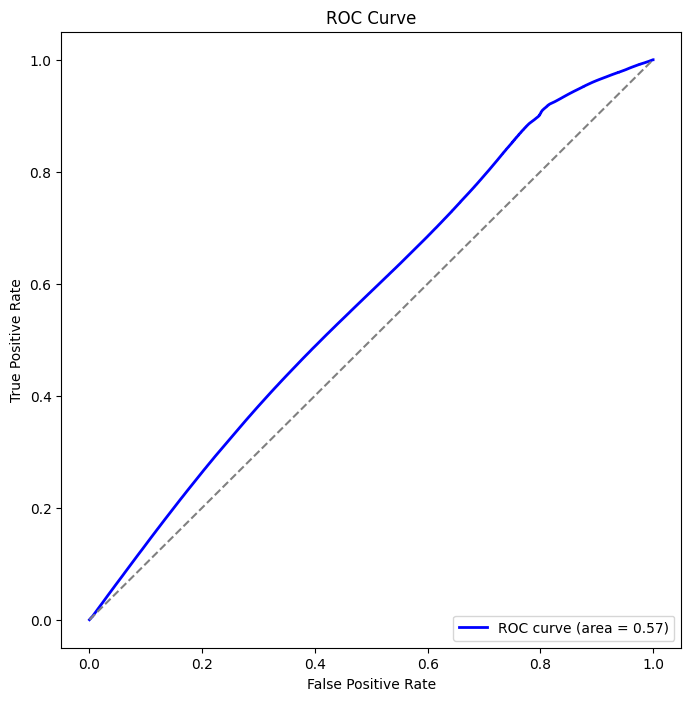

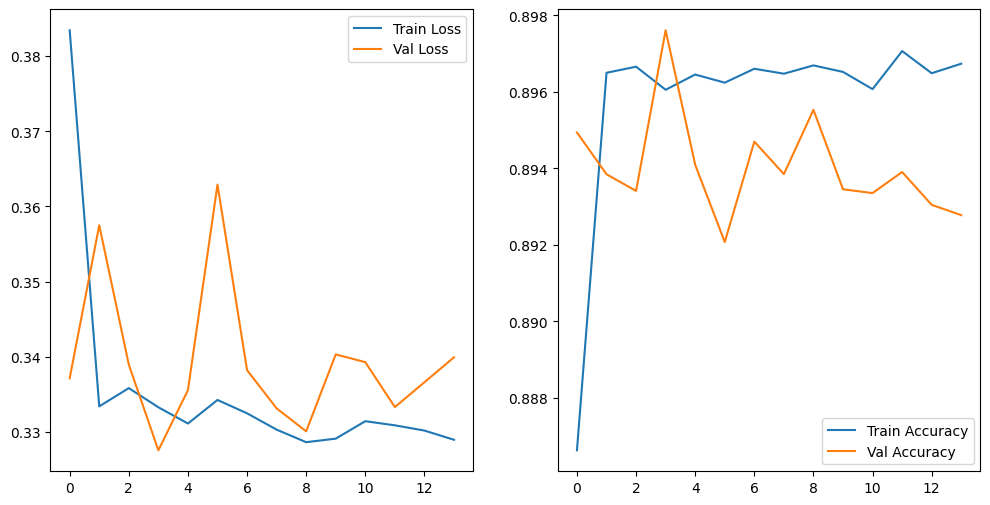

Accuracy: 0.8878,  IoU: 0.1122


In [ ]:
# Metrics calculations
accuracy = accuracy_score(y_true_flat, y_pred_flat > 0.5)


def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

iou = compute_iou_masks(y_true_flat, y_pred_flat)
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

# Output metrics
print(f"Accuracy: {accuracy:.4f},  IoU: {iou:.4f}")

In [ ]:
import math
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)


psnr_boxes = compute_psnr_boxes(y_true_flat, y_pred_flat)
dice_boxes = compute_dice_boxes(y_true_flat, y_pred_flat)



print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)

Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes: 10.012807291513441
Dice Coefficient for Segmentation Boxes: 0.01839199449645349


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.8879 - loss: 0.3475


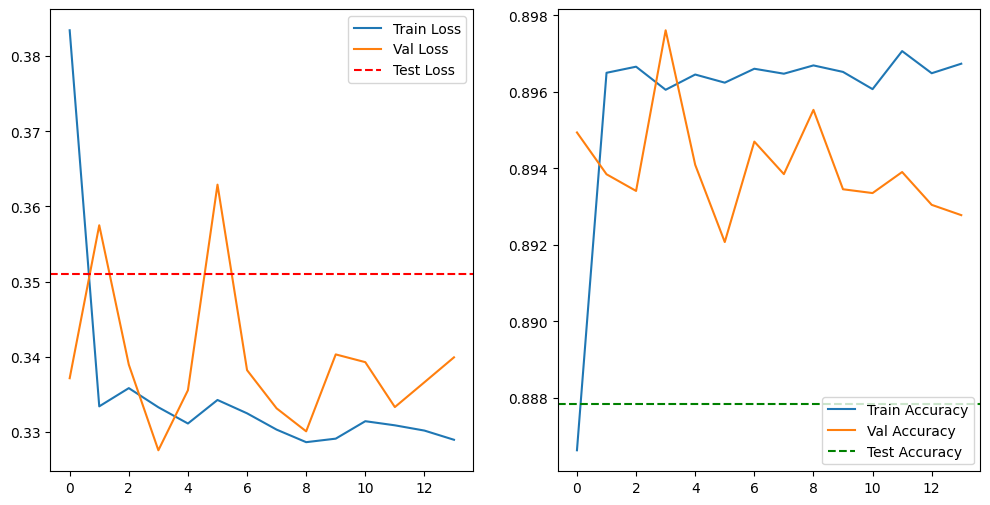

In [ ]:
test_loss, test_accuracy = unet3model.evaluate(test_gen)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.legend()

plt.show()

In [ ]:
#SegNet
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

def segnet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    up6 = Conv2D(512, 3, activation='relu', padding='same')(up6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(up6)
    up7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    up7 = Conv2D(256, 3, activation='relu', padding='same')(up7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(up7)
    up8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    up8 = Conv2D(128, 3, activation='relu', padding='same')(up8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(up8)
    up9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    up9 = Conv2D(64, 3, activation='relu', padding='same')(up9)

    outputs = Conv2D(1, 1, activation='sigmoid')(up9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)


segmodel = segnet_model(input_size=(256, 256, 1))
segmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up generators and callbacks
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
history = segmodel.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

# Evaluation on test set
test_gen = DataGenerator(test_images, test_masks)
y_pred = segmodel.predict(test_gen)
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()



Mounted at /content/drive
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 4191s 50s/step - accuracy: 0.8831 - loss: 0.4512 - val_accuracy: 0.8972 - val_loss: 0.3356
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4134s 50s/step - accuracy: 0.8956 - loss: 0.3368 - val_accuracy: 0.8941 - val_loss: 0.3390
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4149s 50s/step - accuracy: 0.9010 - loss: 0.3285 - val_accuracy: 0.8928 - val_loss: 0.3447
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4088s 49s/step - accuracy: 0.9003 - loss: 0.3298 - val_accuracy: 0.8934 - val_loss: 0.3421
Epoch 5/100
27/83 ━━━━━━━━━━━━━━━━━━━━ 42:42 46s/step - accuracy: 0.8879 - loss: 0.3556

In [ ]:
# Metrics calculations
accuracy = accuracy_score(y_true_flat, y_pred_flat > 0.5)


def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

iou = compute_iou_masks(y_true_flat, y_pred_flat)
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = segmodel.evaluate(test_gen)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.legend()

plt.show()

# Output metrics
print(f"Accuracy: {accuracy:.4f},  IoU: {iou:.4f}")

import math
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)


psnr_boxes = compute_psnr_boxes(y_true_flat, y_pred_flat)
dice_boxes = compute_dice_boxes(y_true_flat, y_pred_flat)



print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)
